### README

#### Energy Drought Co-occurrence Analysis

**Overview**

This script conducts an analysis of the co-occurrence of energy droughts between different countries in Europe.

#### Instructions

**Prerequisites**
- Ensure that the required Python libraries are installed, including `numpy`, `matplotlib`, `seaborn`, `cartopy`, and custom utilities (`utils.py` and `plot_utils.py`).

**Configuration**
1. **File Paths:** Adjust the paths (`ENERGY_PATH`, `ANOM_PATH`, `PSL_PATH`) to match the location of your energy and meteorological datasets.
2. **Analysis Parameters:** Modify parameters like window size, variable type, and row ordering for plotting.
3. **Output Directories:** Update the output directories (`dir_Output`, `dir_Figures`, `dir_MeteoFigures`) to specify where the results and figures will be saved.

**Author**

Bram van Duinen

**Date (last modified)**

2024-01-29

### 1. Preliminaries

In [1]:
import utils as ut
import plot_utils as put

import os
import numpy as np
import pandas as pd
from itertools import combinations, product
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
ENERGY_PATH = '/net/pc200256/nobackup/users/most/output/LENTIS_PD_02/agg_production/per_country/'
ANOM_PATH = '/net/pc230050/nobackup/users/duinen/LENTIS/present/'
PSL_PATH = '/net/pc200256/nobackup/users/most/LENTIS/present/day/psl_d/'
WINDOW = 7
NUM_EVENTS = 1600
VARIABLE = 'residual' # option 2: total_RE

date_now = datetime.now()
rundate = '%4.4i%2.2i%2.2i' % (date_now.year,date_now.month,date_now.day)
dir_Output = f'../Results/Data/{rundate}/{VARIABLE}/concurrent_probs_{WINDOW}d/'
dir_Figures = f'../Results/Figures/{rundate}/{VARIABLE}/concurrent_probs_{WINDOW}d/'

In [3]:
PATH_ED = '../../energydroughts-Europe/data/'
ed = pd.read_csv(os.path.join(PATH_ED, f'residual_el7_winter_LENTIS_PD_02_v4_{NUM_EVENTS}_events.csv')).reset_index(drop=True)
ed['run'] = ed['runs'].str.extract('(\d+)').astype(int)
df_events = ed.drop(['Unnamed: 0', 'runs'], axis = 1)

In [4]:
ut.check_make_dir(dir_Output)
ut.check_make_dir(dir_Figures)

data = ut.load_data(ENERGY_PATH, VARIABLE, stacked = False)

cluster_path = "../Results/clusters_v1/clusters_all.csv"
df_wr = pd.read_csv(cluster_path)
df_wr = df_wr[['time', 'run', 'cluster_id']]
df_wr['time'] = pd.to_datetime(df_wr['time'])
df_wr['time'] = df_wr['time'].apply(lambda dt: dt.replace(hour=12, minute=0, second=0)) # set time to noon, to match df. Is daily average anyway

COUNTRY_NR = data.country.values
COUNTRY_NAME = data.country_name.values
country_nr_name = dict(zip(COUNTRY_NR, COUNTRY_NAME))
country_name_nr  = dict(zip(COUNTRY_NAME, COUNTRY_NR))

HOMEDIR = '/usr/people/duinen/MSc-thesis/'
ROW_ORDER = np.load(f'{HOMEDIR}Data/row_order_v20240116.npy') # load the row ordering of the clustered residual heatmap, to follow the same clustering!
CMAP = 'RdBu_r'

### 2. Define functions

In [57]:
def get_co_occurrence(df):
    overlapping_events_list = []
    co_occur_prob_list = []

    grouped_runs = df.groupby('run')

    for run, run_group in tqdm(grouped_runs):
        country_combinations = product(run_group['country'].unique(), repeat=2)

        for country_1, country_2 in country_combinations:
            co_occur = 0 # reset counter

            events_country_1 = run_group[run_group['country'] == country_1].sort_values(by='start_time')
            events_country_2 = run_group[run_group['country'] == country_2].sort_values(by='start_time')

            # Iterate over rows of both DataFrames to check for overlapping events
            for _, event_country_1 in events_country_1.iterrows():
                for _, event_country_2 in events_country_2.iterrows():

                    if event_country_1['end_time'] >= event_country_2['start_time'] and \
                       event_country_2['end_time'] >= event_country_1['start_time']:
                        co_occur += 1

                        overlapping_events_list.append({
                            'country_1': country_1,
                            'event_number_1': event_country_1['event_number'],
                            'start_time_1': event_country_1['start_time'],
                            'end_time_1': event_country_1['end_time'],
                            'country_2': country_2,
                            'event_number_2': event_country_2['event_number'],
                            'start_time_2': event_country_2['start_time'],
                            'end_time_2': event_country_2['end_time'],
                            'run': run
                        })

            co_occur_prob_list.append({
                'country_1': country_1,
                'country_2': country_2,
                'run': run,
                'prob': co_occur
            })

    overlapping_events_df = pd.DataFrame(overlapping_events_list)
    co_occur_prob_df = pd.DataFrame(co_occur_prob_list)

    co_occur_prob_df = co_occur_prob_df.groupby(['country_1', 'country_2'], as_index=False)['prob'].sum()
    co_occur_prob_df['prob'] = co_occur_prob_df['prob'] / NUM_EVENTS
    return overlapping_events_df, co_occur_prob_df

### 3. Perform co-occurrence analysis

In [60]:
events_df, prob_df = get_co_occurrence(df = df_events)

  0%|          | 0/160 [00:00<?, ?it/s]

In [62]:
country_mapping = {country: i for i, country in enumerate(COUNTRY_NAME[ROW_ORDER])}

In [72]:
prob_df.sort_values(by='prob', ascending=False)[33:66]

,country_1,country_2,prob,country_1_index,country_2_index
214,CZE,HUN,0.863125,10,14
534,HUN,CZE,0.863125,14,10
831,POL,CZE,0.845000,11,10
223,CZE,POL,0.845000,10,11
963,SVK,CZE,0.835000,15,10
227,CZE,SVK,0.835000,10,15
747,MNE,MKD,0.828125,30,29
715,MKD,MNE,0.828125,29,30
553,HUN,POL,0.825000,14,11
841,POL,HUN,0.825000,11,14


[Text(0.5, 58.7222222222222, ''), Text(95.72222222222221, 0.5, '')]

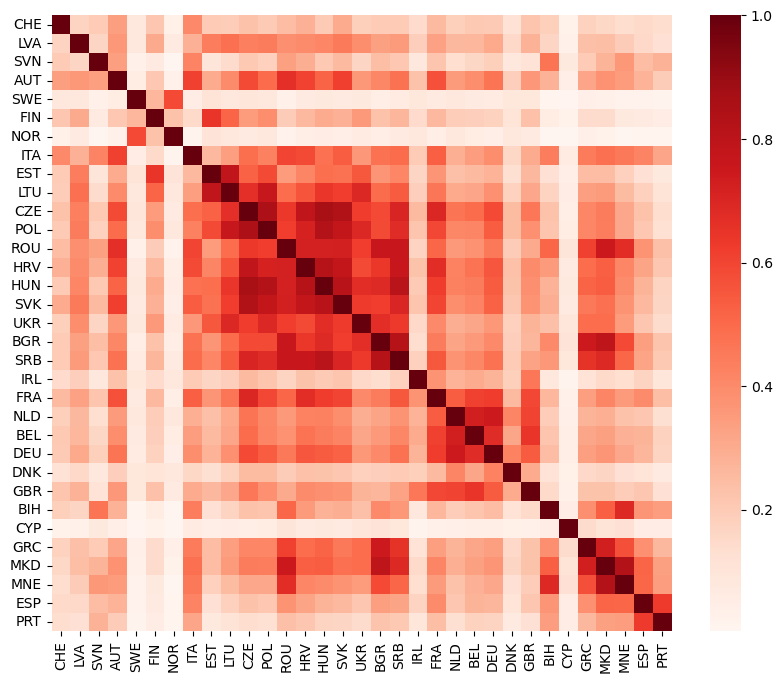

In [66]:
prob_df['country_1_index'] = prob_df['country_1'].map(country_mapping)
prob_df['country_2_index'] = prob_df['country_2'].map(country_mapping)

prob_df['prob'] = pd.to_numeric(prob_df['prob'])

heatmap_data = prob_df.pivot(index = ['country_1_index'], columns = ['country_2_index'], values = 'prob')
                
plt.figure(figsize=(10, 8))
hm = sns.heatmap(heatmap_data, cmap='Reds', xticklabels=COUNTRY_NAME[ROW_ORDER], yticklabels=COUNTRY_NAME[ROW_ORDER])
hm.set(xlabel=None, ylabel=None)